# Entrenamiento de modelo <span style="color:blue">DBSCAN</span>
### En esta sección se llevará a cabo el entrenamiento de los modelos de aprendizaje no supervisado

In [1]:
#importación de librerias
from sklearn import preprocessing
import pandas as pd
import numpy as np
import locale

In [14]:
#Carga de los datos previamente procesados
locale.setlocale(locale.LC_ALL,'')
#Carga de datos
datos_entrenamiento = pd.read_csv("df_censo_aprendizaje_no_supervisado_v2.csv",
                              delimiter = ',', header=0, 
                              encoding='utf-8')
#eliminar la columna del indice
datos_entrenamiento = datos_entrenamiento.drop(datos_entrenamiento.columns[0], axis=1)

In [15]:
display(datos_entrenamiento)

,MUNICIPIO_persona,PCP5_persona,PCP6_persona,PCP7_persona,PCP9_persona,LUGNACGEO_persona,PCP12_persona,PCP13_persona,PCP14_persona,PCP15_persona,...,PCP32_1D_jefe_hogar,PCP33_jefe_hogar,PCP33_B_jefe_hogar,TRABAJAGEO_jefe_hogar,PCP34_jefe_hogar,VIVEHABGEO_jefe_hogar,NIVGRADO_jefe_hogar,ANEDUCA_jefe_hogar,MIGRA_VIDA_jefe_hogar,MIGRA_REC_jefe_hogar
0,0.045557,0.933333,1.0,1.00,0.111111,0.000000,0.833333,0.0,0.0,0.255102,...,0.080808,0.111111,0.045455,0.043932,0.285714,0.045557,0.638889,0.571429,0.5,0.5
1,0.045557,0.400000,1.0,0.75,0.111111,0.043932,0.833333,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.045557,0.625000,0.523810,0.5,0.5
2,0.045557,0.400000,1.0,0.50,0.111111,0.043932,0.833333,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.045557,0.625000,0.523810,0.5,0.5
3,0.045557,0.733333,0.5,0.75,1.000000,0.043932,0.833333,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.857143,0.045557,0.430556,0.047619,0.5,1.0
4,0.045557,0.400000,0.5,0.00,0.111111,0.043932,0.833333,0.0,0.0,0.000000,...,0.090909,0.111111,0.045455,0.043932,0.285714,0.045557,0.458333,0.142857,1.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681885,0.993234,1.000000,1.0,0.50,0.111111,0.958243,0.833333,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1681886,0.993234,1.000000,0.5,0.50,0.111111,0.957373,0.833333,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1681887,0.993234,1.000000,0.5,0.25,0.111111,0.963027,0.833333,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1681888,0.993234,1.000000,0.5,0.25,0.111111,0.964332,0.833333,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


# <span style="color:blue">Busqueda aleatoria de hiper-parametros</span>
## Proceso más costoso, la busqueda de los mejores valores para los hiper-parametros

In [3]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
import random
import time

In [4]:
#obtener valores de hiper-parametros a utilizar para busqueda
num_busquedas = 3
hiper_eps =[]
ix = 0
while ix<num_busquedas:
    hip_t = round(random.uniform(0.05, 2),2)
    if hip_t not in hiper_eps:
        hiper_eps.append(hip_t)
        ix +=1
        
num_busquedas = 4
hiper_min_pts =[]
ix = 0
while ix<num_busquedas:
    hip_t = int(random.uniform(2, 8))
    if hip_t not in hiper_min_pts:
        hiper_min_pts.append(hip_t)
        ix +=1       

In [16]:
print(hiper_eps)
print(hiper_min_pts)

[0.05, 1, 0.6]
[4, 6, 3, 7]


In [17]:
#--Metodo creado para obtener las metricas de un modelo
# hiper_p_eps = valor utilizado de eps
# hiper_p_min_samples = valor utilizado de min_samples
# datos_entrenamiento = datos utilizados para el entrenamiento del modelo
# labels = labels resultantes del modelo
# tamanio_muestra = tamaño de la muestra a utilizar para calcular la metrica silhoutte
# imprimir_datos = indica si adicionalmente a devolver los parametros debe imprimirlos en pantalla
# start= tiempo de inicio del entrenamiento del modelo, utilizado para calcular el tiempo que tarde el modelo en entrenarse
def obtener_metricas(hiper_p_eps,hiper_p_min_samples, datos_entrenamiento, labels, tamanio_muestra, imprimir_datos, start):    
    #Generacion de métricas
    #start = time.process_time()

    #Despliegue de metricas del modelo resultante
    # 0. Hiper parametros utilizados
    if imprimir_datos:
        print('Modelo ejecutado utilizando los hiper-parametros: eps=%0.3f , min_samples= %d' % (hiper_p_eps,
                                                                                                 hiper_p_min_samples))
        print("-----------------------------")

    # 1.Número de clusters generados:
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    if imprimir_datos:
        print('Número de Clusters generados por el modelo: %d' % n_clusters_)

    # 2.Número de puntos excluidos (considerados como ruido)
    n_noise_ = list(labels).count(-1)
    if imprimir_datos:
        print('Puntos del modelo considerados como ruido: %d' % n_noise_)

    # 3.calinski_harabasz_score
    #   Criterio del radio de varianza
    #   Se define como la relación entre la dispersión dentro del grupo y la dispersión entre grupos
    #   Conforme los valores son más altos, indican mejores resultados
    #   https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html#sklearn.metrics.calinski_harabasz_score
    metrica_calinski = metrics.calinski_harabasz_score(datos_entrenamiento, labels)
    if imprimir_datos:
        print("calinski harabasz score: %0.3f" % metrica_calinski)

    # 4.davies_bouldin_score
    #   El puntaje se define como la medida de similitud promedio de cada cluster con su grupo más similar, 
    #   donde la similitud es la relación entre las distancias dentro del grupo y las distancias entre grupos. 
    #   Por lo tanto, los grupos que están más separados y menos dispersos resultarán en una mejor puntuación.
    #   Valores más bajos indican mejores resultados
    #   https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html#sklearn.metrics.davies_bouldin_score
    metrica_davies_bou =metrics.davies_bouldin_score(datos_entrenamiento, labels)
    if imprimir_datos:
        print("davies bouldin score: %0.3f" % metrica_davies_bou)

    # 5.silhouette_score
    #   El coeficiente se calcula utilizando la distancia media intra-cluster y la media del cluster mas cercano.
    #   El valor que indica mejores resultados es 1 y peores resultados es -1
    #   https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score
    metrica_silhouette = metrics.silhouette_score(datos_entrenamiento, labels, sample_size=tamanio_muestra)
    if imprimir_datos:
        print("Silhouette Coefficient: %0.3f" % metrica_silhouette)
        print("Tiempo para generación de métricas (segundos): "+str(time.time() - start))
    
    new_row = {'hp':"eps="+str(hiper_p_eps)+ "; min_samples="+str(hiper_p_min_samples),'clusters':n_clusters_,
               'p_ruido':n_noise_, 'calinski_harabasz_score':metrica_calinski,
               'davies_bouldin_score':metrica_davies_bou, 'silhouette_score': metrica_silhouette,
               'tiempo_ejec':str(time.time() - start)}
    
    return new_row

#### busqueda de hiper parametros (se realiza una ejecución por cada valor de eps)

In [63]:
#ejecutar modelos en busqueda aleatoria para encontrar la mejor combinación de hiper-parametros
#proceso costoso en tiempo y procesamiento
start =  time.time()
datos_label = pd.DataFrame()
matriz_hiper_p = pd.DataFrame(columns = ['hp','clusters','p_ruido', 'calinski_harabasz_score', 'davies_bouldin_score',
                                         'silhouette_score', 'tiempo_ejec'])

#Realizar la iteración únicamente con un elemento de eps, de lo contrario se generar memory error
#for item_eps in hiper_eps:
item_eps = hiper_eps[0]
for item_min_pts in hiper_min_pts:
    partial_start = time.time()
    cluster_1 = DBSCAN(eps=item_eps, min_samples=item_min_pts, n_jobs=-1).fit(datos_entrenamiento)
    #guardar resultados
    datos_label["eps="+str(item_eps)+ "; min_samples="+str(item_min_pts)] = cluster_1.labels_.tolist()    

    new_row = obtener_metricas(item_eps, item_min_pts, datos_entrenamiento, cluster_1.labels_, 50000, False, partial_start)
    matriz_hiper_p = matriz_hiper_p.append(new_row, ignore_index=True)
    print("iteración: "+"eps="+str(item_eps)+ "; min_samples="+str(item_min_pts))
    del cluster_1                
    
#print("Tiempo utilizado para busqueda de hiper-parametros (segundos): %d"%( time.time() - start))        

iteración: eps=0.05; min_samples=4
iteración: eps=0.05; min_samples=6
iteración: eps=0.05; min_samples=3
iteración: eps=0.05; min_samples=7


In [47]:
display(matriz_hiper_p)

,hp,clusters,p_ruido,calinski_harabasz_score,davies_bouldin_score,silhouette_score,tiempo_ejec
0,eps=0.05; min_samples=4,84,1681487,22.972489,0.571072,0.017777,5041.471709251404
1,eps=0.05; min_samples=6,16,1681776,42.832233,0.448276,0.175640,5086.292111635208
2,eps=0.05; min_samples=3,350,1680688,10.385420,0.800071,-0.318195,5008.704766988754
3,eps=0.05; min_samples=7,9,1681818,48.150947,0.452434,0.176463,4826.647037267685


<hr/>

In [69]:
#ejecutar modelos en busqueda aleatoria para encontrar la mejor combinación de hiper-parametros
start =  time.time()

#Realizar la iteración únicamente con un elemento de eps, de lo contrario se generar memory error
item_eps = hiper_eps[1]
for item_min_pts in hiper_min_pts:
    partial_start = time.time()
    cluster_1 = DBSCAN(eps=item_eps, min_samples=item_min_pts, n_jobs=-1).fit(datos_entrenamiento)
    #guardar resultados
    datos_label["eps="+str(item_eps)+ "; min_samples="+str(item_min_pts)] = cluster_1.labels_.tolist()    

    new_row = obtener_metricas(item_eps, item_min_pts, datos_entrenamiento, cluster_1.labels_, 50000, False, partial_start)
    matriz_hiper_p = matriz_hiper_p.append(new_row, ignore_index=True)
    print("iteración: "+"eps="+str(item_eps)+ "; min_samples="+str(item_min_pts))
    del cluster_1                
    
#print("Tiempo utilizado para busqueda de hiper-parametros (segundos): %d"%( time.time() - start)) 

iteración: eps=1; min_samples=4
iteración: eps=1; min_samples=6
iteración: eps=1; min_samples=3
iteración: eps=1; min_samples=7


In [80]:
display(matriz_hiper_p)

,hp,clusters,p_ruido,calinski_harabasz_score,davies_bouldin_score,silhouette_score,tiempo_ejec
0,eps=0.05; min_samples=4,84,1681487,22.972489,0.571072,0.017777,5041.471709
1,eps=0.05; min_samples=6,16,1681776,42.832233,0.448276,0.175640,5086.292112
2,eps=0.05; min_samples=3,350,1680688,10.385420,0.800071,-0.318195,5008.704767
3,eps=0.05; min_samples=7,9,1681818,48.150947,0.452434,0.176463,4826.647037
4,eps=1.0; min_samples=4,1411,244159,48.039058,1.367056,-0.298098,64825.426077
5,eps=1.0; min_samples=6,362,266145,170.470109,1.471702,-0.241883,64903.800784
6,eps=1.0; min_samples=3,4487,224588,18.274266,1.332524,-0.348124,64341.358037
7,eps=1.0; min_samples=7,233,273743,256.430979,1.507993,-0.218171,64128.330324


<hr />

In [13]:
#ejecutar modelos en busqueda aleatoria para encontrar la mejor combinación de hiper-parametros
start =  time.time()

#Realizar la iteración únicamente con un elemento de eps, de lo contrario se generar memory error
item_eps = hiper_eps[2]
for item_min_pts in hiper_min_pts:
    partial_start = time.time()
    cluster_1 = DBSCAN(eps=item_eps, min_samples=item_min_pts, n_jobs=-1).fit(datos_entrenamiento)
    #guardar resultados
    datos_label["eps="+str(item_eps)+ "; min_samples="+str(item_min_pts)] = cluster_1.labels_.tolist()    

    new_row = obtener_metricas(item_eps, item_min_pts, datos_entrenamiento, cluster_1.labels_, 50000, False, partial_start)
    matriz_hiper_p = matriz_hiper_p.append(new_row, ignore_index=True)
    print("iteración: "+"eps="+str(item_eps)+ "; min_samples="+str(item_min_pts))
    del cluster_1                
    
#print("Tiempo utilizado para busqueda de hiper-parametros (segundos): %d"%( time.time() - start)) 

iteración: eps=0.6; min_samples=4
iteración: eps=0.6; min_samples=6
iteración: eps=0.6; min_samples=3
iteración: eps=0.6; min_samples=7


In [44]:
display(matriz_hiper_p)

,hp,clusters,p_ruido,calinski_harabasz_score,davies_bouldin_score,silhouette_score,tiempo_ejec
0,eps=0.05; min_samples=4,84,1681487,22.972489,0.571072,0.017777,5041.47
1,eps=0.05; min_samples=6,16,1681776,42.832233,0.448276,0.175640,5086.29
2,eps=0.05; min_samples=3,350,1680688,10.385420,0.800071,-0.318195,5008.7
3,eps=0.05; min_samples=7,9,1681818,48.150947,0.452434,0.176463,4826.65
4,eps=1.0; min_samples=4,1411,244159,48.039058,1.367056,-0.298098,64825.4
5,eps=1.0; min_samples=6,362,266145,170.470109,1.471702,-0.241883,64903.8
6,eps=1.0; min_samples=3,4487,224588,18.274266,1.332524,-0.348124,64341.4
7,eps=1.0; min_samples=7,233,273743,256.430979,1.507993,-0.218171,64128.3
8,eps=0.6; min_samples=4,8426,1196511,27.480312,1.390332,-0.466110,29532.007641792297
9,eps=0.6; min_samples=6,2180,1269379,90.019431,1.458667,-0.440891,29623.94667983055


<hr/>

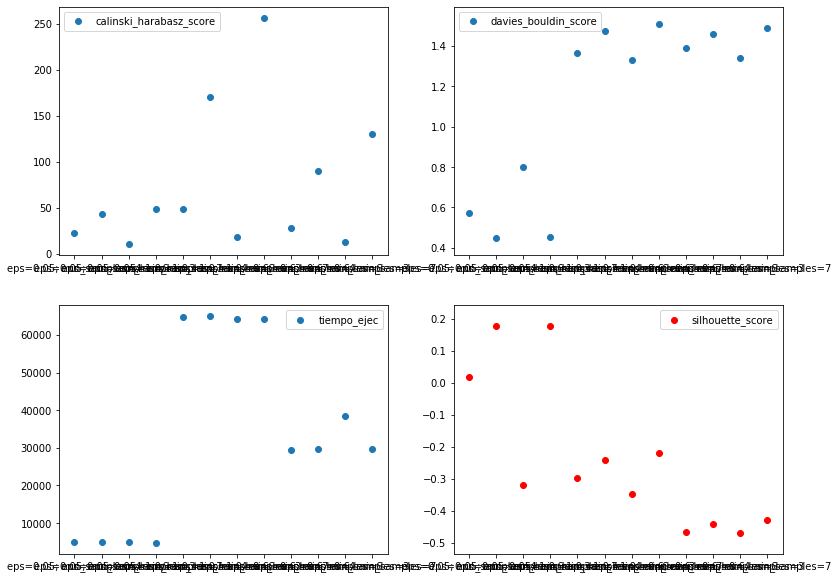

In [50]:
#Grafica del resultado de busqueda aleatoria de hiper-parametros
import matplotlib.pyplot as plt
#graficado:
figura, graficas = plt.subplots(2,2) #crear una matriz de 2 x 2 para plot
graficas[0,0].scatter(matriz_hiper_p["hp"], matriz_hiper_p["calinski_harabasz_score"], label="calinski_harabasz_score")
graficas[0,1].scatter(matriz_hiper_p["hp"], matriz_hiper_p["davies_bouldin_score"], label="davies_bouldin_score") 
graficas[1,1].scatter(matriz_hiper_p["hp"], matriz_hiper_p["silhouette_score"], color="r", label="silhouette_score") 
graficas[1,0].scatter(matriz_hiper_p["hp"], matriz_hiper_p["tiempo_ejec"], label="tiempo_ejec") 

plt.subplots_adjust(bottom=-0.1, right=1.8, top=1.8)

graficas[0,0].legend()
graficas[0,1].legend()
graficas[1,1].legend()
graficas[1,0].legend()

plt.show()

# <span style="color:blue">Guardar resultados</span>
## Se almacenan los resultados obtenidos con los modelos entrenados

In [46]:
#Agregar columnas de clase objetivo
for column in datos_label.columns:
    datos_entrenamiento[column] = datos_label[column]

In [47]:
# Crear columna calculada con información del municipio para esto se realiza el inverso de MaxAbsScaler
# por lo cual basta con multiplicarla por el valor maximo de municipio
datos_entrenamiento['MUNICIPIO_calc'] = round(datos_entrenamiento.MUNICIPIO_persona *2217)

In [48]:
#mostrar datos finales
display(datos_entrenamiento)
print()
display(matriz_hiper_p)

,MUNICIPIO_persona,PCP5_persona,PCP6_persona,PCP7_persona,PCP9_persona,LUGNACGEO_persona,PCP12_persona,PCP13_persona,PCP14_persona,PCP15_persona,...,eps=0.05; min_samples=7,eps=1.0; min_samples=4,eps=1.0; min_samples=6,eps=1.0; min_samples=3,eps=1.0; min_samples=7,eps=0.6; min_samples=4,eps=0.6; min_samples=6,eps=0.6; min_samples=3,eps=0.6; min_samples=7,MUNICIPIO_calc
0,0.045557,0.933333,1.0,1.00,0.111111,0.000000,0.833333,0.0,0.0,0.255102,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,101.0
1,0.045557,0.400000,1.0,0.75,0.111111,0.043932,0.833333,0.0,0.0,0.000000,...,-1,0,-1,0,-1,-1,-1,-1,-1,101.0
2,0.045557,0.400000,1.0,0.50,0.111111,0.043932,0.833333,0.0,0.0,0.000000,...,-1,0,0,0,0,-1,-1,-1,-1,101.0
3,0.045557,0.733333,0.5,0.75,1.000000,0.043932,0.833333,0.0,0.0,0.000000,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,101.0
4,0.045557,0.400000,0.5,0.00,0.111111,0.043932,0.833333,0.0,0.0,0.000000,...,-1,0,0,0,0,-1,-1,-1,-1,101.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681885,0.993234,1.000000,1.0,0.50,0.111111,0.958243,0.833333,0.0,0.0,0.000000,...,-1,1409,360,4485,231,8418,2172,24061,1429,2202.0
1681886,0.993234,1.000000,0.5,0.50,0.111111,0.957373,0.833333,0.0,0.0,0.000000,...,-1,1409,360,4485,231,8418,2172,24061,1429,2202.0
1681887,0.993234,1.000000,0.5,0.25,0.111111,0.963027,0.833333,0.0,0.0,0.000000,...,-1,1409,360,4485,231,8418,2172,24061,1429,2202.0
1681888,0.993234,1.000000,0.5,0.25,0.111111,0.964332,0.833333,0.0,0.0,0.000000,...,-1,1409,360,4485,231,8418,2172,24061,1429,2202.0


,hp,clusters,p_ruido,calinski_harabasz_score,davies_bouldin_score,silhouette_score,tiempo_ejec
0,eps=0.05; min_samples=4,84,1681487,22.972489,0.571072,0.017777,5041.47
1,eps=0.05; min_samples=6,16,1681776,42.832233,0.448276,0.175640,5086.29
2,eps=0.05; min_samples=3,350,1680688,10.385420,0.800071,-0.318195,5008.7
3,eps=0.05; min_samples=7,9,1681818,48.150947,0.452434,0.176463,4826.65
4,eps=1.0; min_samples=4,1411,244159,48.039058,1.367056,-0.298098,64825.4
5,eps=1.0; min_samples=6,362,266145,170.470109,1.471702,-0.241883,64903.8
6,eps=1.0; min_samples=3,4487,224588,18.274266,1.332524,-0.348124,64341.4
7,eps=1.0; min_samples=7,233,273743,256.430979,1.507993,-0.218171,64128.3
8,eps=0.6; min_samples=4,8426,1196511,27.480312,1.390332,-0.466110,29532.007641792297
9,eps=0.6; min_samples=6,2180,1269379,90.019431,1.458667,-0.440891,29623.94667983055


In [49]:
#Guardar en disco los resultados
datos_entrenamiento.to_csv('df_dbscan_datos_y_v3.csv', encoding='utf-8')
matriz_hiper_p.to_csv('df_dbscan_metricas_v3.csv', encoding='utf-8')